#### Import packages and device selection

In [1]:
import gc
import os
import re
import cv2
from tqdm.notebook import tqdm
import optuna
from optuna.trial import TrialState
import torch
from torch import nn, optim
from torch.utils.checkpoint import checkpoint
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchinfo import summary
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SIZE = 160
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32  = True

In [3]:
print("Using device: ", device)

Using device:  cuda


## Dataset Loading and Preprocessing

In [4]:
def sort_files(folder):
    convert_func = lambda x: int(x) if x.isdigit() else x.lower()
    key_func = lambda x: [convert_func(c) for c in re.split('([0-9]+)', x)]
    return sorted(folder, key=key_func)

input_L = []
target_ab = []
path = '../data/color'
folder = os.listdir(path)
folder = sort_files(folder)
for file in tqdm(folder, desc='Loading color images'):
    img = cv2.imread(os.path.join(path, file), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img = cv2.resize(img, (SIZE, SIZE))
    L = img[:, :, 0:1] / 255.0 # (H, W, 1) [0..1]
    ab = img[:, :, 1:3] # (H, W, 2) [0..255]
    input_L.append(L)
    target_ab.append(ab)
input_L = np.array(input_L).astype(np.float32) # (N, H, W, 1)
target_ab = np.array(target_ab).astype(np.uint8) # (N, H, W, 2)

Loading color images:   0%|          | 0/7129 [00:00<?, ?it/s]

In [5]:
print(input_L.shape, target_ab.shape)

(7129, 160, 160, 1) (7129, 160, 160, 2)


#### Display some samples

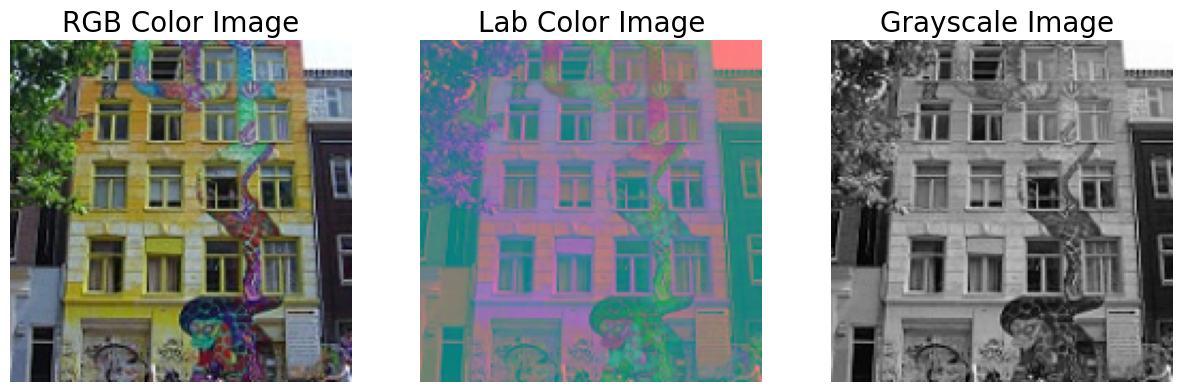

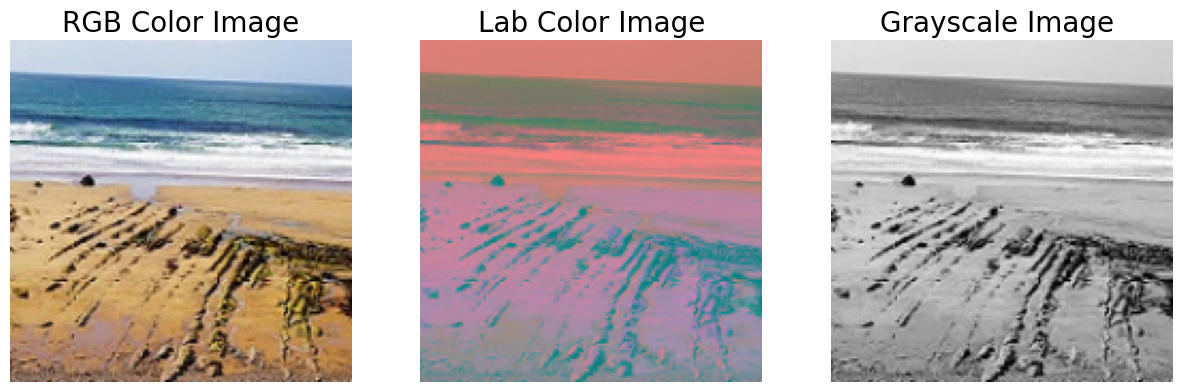

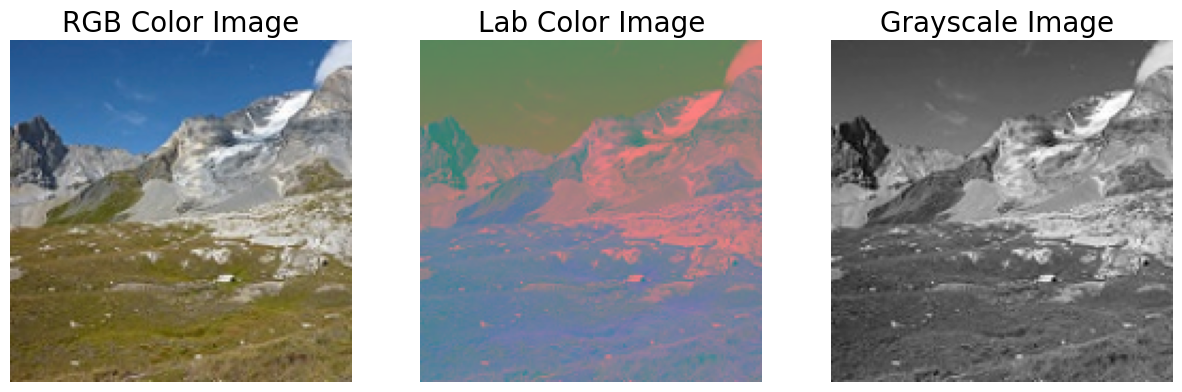

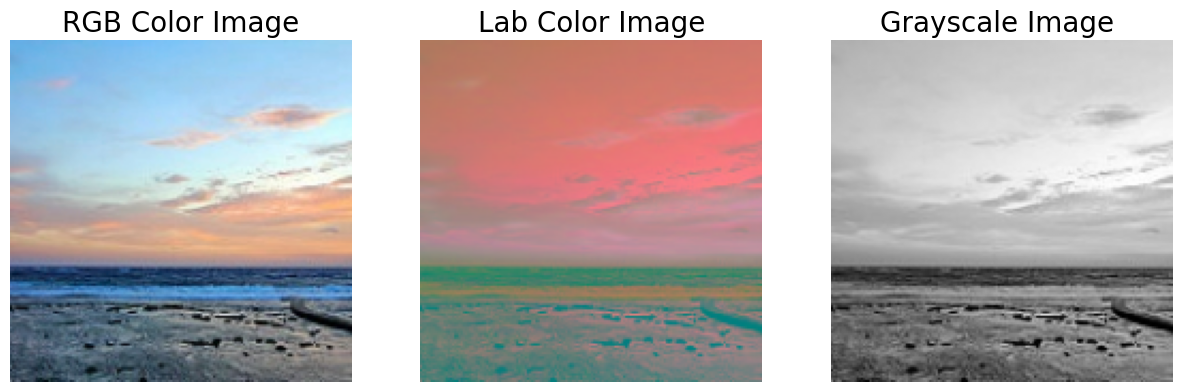

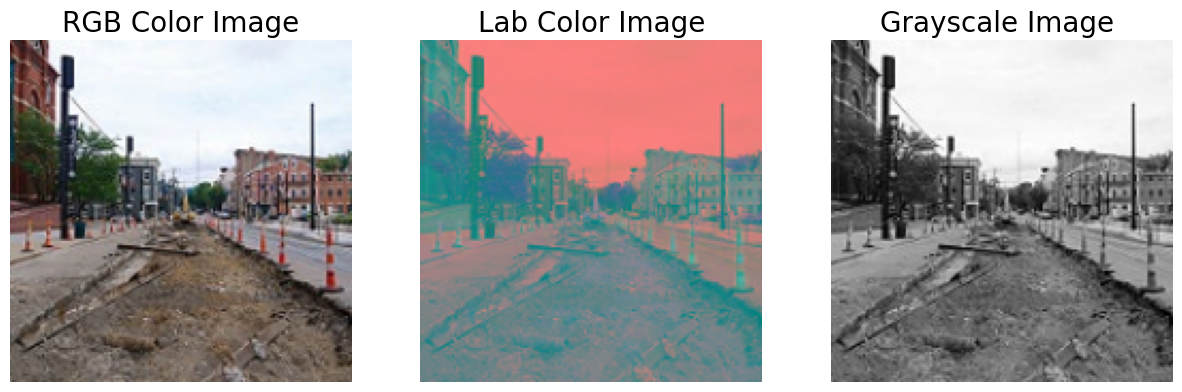

In [6]:
for _ in range(5):
    idx = np.random.randint(0, len(input_L) - 1)
    color_img = np.concatenate([input_L[idx] * 255, target_ab[idx]], axis=2).astype(np.uint8)
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('RGB Color Image', fontsize=20)
    plt.imshow(np.clip(cv2.cvtColor(color_img, cv2.COLOR_LAB2RGB), 0, 255))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Lab Color Image', fontsize=20)
    plt.imshow(color_img)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Grayscale Image ', fontsize=20)
    plt.imshow((input_L[idx] * 255).astype(np.uint8).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

#### Split into training and test data

In [7]:
input_L = np.transpose(input_L, (0, 3, 1, 2)) # (N, 1, H, W)
target_ab = np.transpose(target_ab, (0, 3, 1, 2)) # (N, 2, H, W)
L_train, L_test, ab_train, ab_test = train_test_split(input_L, target_ab, test_size=0.3, random_state=42)
L_val, L_test, ab_val, ab_test = train_test_split(L_test, ab_test, test_size=0.3, random_state=42)
del input_L, target_ab
L_train = torch.tensor(L_train, dtype=torch.float32)
ab_train = torch.tensor(ab_train, dtype=torch.uint8)
L_val = torch.tensor(L_val, dtype=torch.float32)
ab_val = torch.tensor(ab_val, dtype=torch.uint8)
L_test = torch.tensor(L_test, dtype=torch.float32)
ab_test = torch.tensor(ab_test, dtype=torch.uint8)

In [8]:
print(L_train.shape, ab_train.shape)
print(L_val.shape, ab_val.shape)
print(L_test.shape, ab_test.shape)

torch.Size([4990, 1, 160, 160]) torch.Size([4990, 2, 160, 160])
torch.Size([1497, 1, 160, 160]) torch.Size([1497, 2, 160, 160])
torch.Size([642, 1, 160, 160]) torch.Size([642, 2, 160, 160])


In [9]:
L_mean = L_train.mean(dim=(0, 2, 3), dtype=torch.float32)
L_std = L_train.std(dim=(0, 2, 3), )

RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Byte

In [ ]:
print(L_mean, L_std)

In [ ]:
def unstandardize(tensor, mean, std):
    og_shape = tensor.shape
    C, H, W = og_shape[-3:]
    tensor = (tensor.reshape(-1, C, H, W) * std.reshape(1, C, 1, 1) + mean.reshape(1, C, 1, 1)).clamp(0, 1)  # unnormalize to [0, 1]
    return tensor.reshape(og_shape)  # restore original shape

def compute_ab_prior(dataloader):
    hist = torch.zeros(313)
    total = 0
    for _, labels in dataloader:
        hist += torch.bincount(labels.reshape(-1), minlength=313)  # accumulate histogram
        total += labels.numel()
        del labels
    return hist / total # p(c)

def make_rebalancing_weights(priors, alpha=0.5):
    C = priors.size(0)
    uniform = torch.full_like(priors, 1.0 / C, device=device)
    smoothed = (1.0 - alpha) * uniform + alpha * priors
    weights = 1.0 / smoothed # inverse of smoothed priors (Cross entropies) [0..inf]
    return weights / weights.mean()

def lab_to_rgb(x):
    lab = x.permute(1, 2, 0)
    L = (lab[:, :, 0] * 255).cpu().numpy().astype(np.uint8)
    a = (lab[:, :, 1] * 255).cpu().numpy().astype(np.uint8)
    b = (lab[:, :, 2] * 255).cpu().numpy().astype(np.uint8)
    lab_cv = np.stack([L, a, b], axis=2)
    rgb = cv2.cvtColor(lab_cv, cv2.COLOR_LAB2RGB)
    return rgb

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, L_data, ab_data, lut, L_transform=None):
        self.L_data = L_transform(L_data) if L_transform else L_data
        lut = lut.cpu()
        with torch.no_grad():
            a = ab_data[:, 0, :, :].long()
            b = ab_data[:, 1, :, :].long()
            idx = (a * 256 + b).reshape(a.size(0), -1)
            labels = lut[idx]
            self.labels = labels.reshape_as(a)
        del ab_data, ab, a, b, idx, labels, lut
    def __len__(self):
        return self.L_data.size(0)

    def __getitem__(self, idx):
        return self.L_data[idx], self.labels[idx]

In [ ]:
class CUDAPrefetcher:
    def __init__(self, loader):
        self.loader = iter(loader)
        self.stream = torch.cuda.Stream()
        self.next_L = None
        self.next_labels = None
        self._preload()

    def _preload(self):
        try:
            self.next_L, self.next_labels = next(self.loader)
        except StopIteration:
            self.next_L = None
            return
        with torch.cuda.stream(self.stream):
            self.next_L = self.next_L.to(device, memory_format=torch.channels_last, non_blocking=True)
            self.next_labels = self.next_labels.to(device, non_blocking=True)

    def next(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        L, labels = self.next_L, self.next_labels
        self._preload()
        return L, labels

## Training pipeline

In [ ]:
cluster_path = '../data/pts_in_hull.npy'
assert os.path.exists(cluster_path), "Download pts_in_hull.npy and place next to this script"
cluster_centers = torch.from_numpy(np.load(cluster_path)).float() # (313, 2) [-128..127]
cc_l2 = (cluster_centers ** 2).sum(dim=1) # (313,)
lut_coords  = (((torch.stack(torch.meshgrid(torch.arange(256), torch.arange(256), indexing='xy'), dim=-1).float()) - 128.0)
               .reshape(-1, 2)) # (65536, 2) [-128..127]

def compute_dist(tensor):
    dists = ((tensor ** 2).sum(dim=1, keepdim=True) # (B*H*W, 1)
             + cc_l2.reshape(1, -1) # (1, 313)
             - 2 * torch.matmul(tensor, cluster_centers.t())) # (B*H*W, 313)
    return dists

dists = compute_dist(lut_coords)
del lut_coords
# lut = torch.argmin(dists, dim=1).long() # (65536,) [0..312] LUT for mapping (a, b) to cluster index
soft_lut_probs = torch.softmax(-dists, dim=1)  # shape: (65536, 313)
lut = torch.argmax(soft_lut_probs, dim=1).long()  # shape: (65536,)
del dists

In [ ]:
trainset = MyDataset(L_train, ab_train, lut, L_transform=transforms.Normalize(mean=L_mean, std=L_std))
valset = MyDataset(L_val, ab_val, lut, L_transform=transforms.Normalize(mean=L_mean, std=L_std))
testset = MyDataset(L_test, ab_test, lut, L_transform=transforms.Normalize(mean=L_mean, std=L_std))
del L_train, L_test, ab_train, ab_test # release memory

#### Early stopping used to stop training if model begins to overfit

In [ ]:
def save_checkpoint(model, name='checkpoint'):
    torch.save(model.state_dict(), f"../models/{name}.pth")

class EarlyStopping:
    def __init__(self, patience=10, delta=0.05):
        self.patience = patience
        self.counter = 0
        self.best_score = np.Inf
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, net):
        if self.best_score > val_loss:
            self.best_score = val_loss
            self.counter = 0
            save_checkpoint(net)
        elif self.best_score + self.delta < val_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

#### Rebalancing Weights Loss class

In [ ]:
class RebalanceLoss(nn.Module):
    def __init__(self, weights):
        super(RebalanceLoss, self).__init__()
        self.register_buffer('class_weights', weights)
        self.loss_fn = nn.CrossEntropyLoss(weight=self.class_weights, reduction='mean')

    def forward(self, preds, labels):
        return self.loss_fn(preds, labels)

In [ ]:
def fit(net, trainloader, optimizer, scaler, loss_fn, micro_size=64, acc_steps=4):
    net.train()
    loss_sum = torch.zeros(1, device=device) # sum of per-pixel losses
    pixel_acc = torch.zeros(1, device=device) # total correct pixels
    pixel_total = torch.zeros(1, device=device) # total valid pixels
    image_acc = torch.zeros(1, device=device) # sum of per-image accuracies
    image_count = torch.zeros(1, device=device) # count of images contributing to per-image metric
    optimizer.zero_grad(set_to_none=True)
    prefetcher = CUDAPrefetcher(trainloader)
    inputs, targets = prefetcher.next()
    accum_in_window = 0
    while inputs is not None:
        num_chunks = (inputs.size(0) + micro_size - 1) // micro_size
        for inp_mb, tar_mb in zip(inputs.chunk(num_chunks, dim=0), targets.chunk(num_chunks, dim=0)):
            with torch.cuda.amp.autocast():
                out_mb = net(inp_mb)
                loss_mb = loss_fn(out_mb, tar_mb)
            loss_scaled = loss_mb / acc_steps
            scaler.scale(loss_scaled).backward()
            accum_in_window += 1
            with torch.no_grad():
                pred = out_mb.argmax(1) # predicted label for each pixel [B, H, W]
                valid = torch.ones_like(tar_mb, dtype=torch.bool)
                # Pixel accuracy
                correct = (pred == tar_mb) & valid
                pixel_acc += correct.sum()
                batch_valid_pixels = valid.sum()
                pixel_total += batch_valid_pixels
                # Mean per-image accuracy
                # For each image: correct_i / valid_i (skip images with 0 valid pixels)
                B = tar_mb.size(0)
                correct_per = correct.view(B, -1).sum(dim=1)
                valid_per = valid.view(B, -1).sum(dim=1)
                valid_imgs = valid_per > 0
                if valid_imgs.any():
                    image_acc += (correct_per[valid_imgs].float() / valid_per[valid_imgs].float()).sum()
                    image_count += valid_imgs.sum()
                # Loss averaging across epoch:
                # If loss_fn is mean over valid pixels, convert back to sum by multiplying to valid count.
                if batch_valid_pixels.item() > 0:
                    loss_sum += loss_mb.detach() * batch_valid_pixels
            # Step on full accumulation window
            if accum_in_window == acc_steps:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
                accum_in_window = 0
        inputs, targets = prefetcher.next()
    # Handle a final partial accumulation window properly (to keep the same effective loss scale)
    if accum_in_window > 0:
        # We divided each micro-batch by acc_steps; adjust grads by acc_steps/accum_in_window
        # so the step uses the average over the actual number of micro-batches accumulated.
        scaler.unscale_(optimizer)
        adjust = acc_steps / float(accum_in_window)
        for p in net.parameters():
            if p.grad is not None:
                p.grad.mul_(adjust)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    # Safeguards against division by zero
    total_valid_pixels = pixel_total.clamp_min(1)
    total_valid_images = image_count.clamp_min(1)
    return (loss_sum / total_valid_pixels).item(), (pixel_acc / total_valid_pixels).item(), (image_acc / total_valid_images).item()

@torch.inference_mode()
def predict(net, valloader, loss_fn, micro_size=64):
    net.eval()
    loss_sum = torch.zeros(1, device=device)
    pixel_correct = torch.zeros(1, device=device)
    pixel_total = torch.zeros(1, device=device)
    per_image_acc_sum = torch.zeros(1, device=device)
    image_count = torch.zeros(1, device=device)
    prefetcher = CUDAPrefetcher(valloader)
    inputs, targets = prefetcher.next()
    while inputs is not None:
        num_chunks = (inputs.size(0) + micro_size - 1) // micro_size
        for inp_mb, tar_mb in zip(inputs.chunk(num_chunks, dim=0), targets.chunk(num_chunks, dim=0)):
            with torch.cuda.amp.autocast():
                out_mb = net(inp_mb)
                loss_mb = loss_fn(out_mb, tar_mb)  # scalar loss over valid pixels
            pred = out_mb.argmax(1)  # [B, H, W]
            valid = torch.ones_like(tar_mb, dtype=torch.bool)
            # Pixel-wise
            correct = (pred == tar_mb) & valid
            pixel_correct += correct.sum()
            pixel_total += valid.sum()
            # Per-image accuracy
            B = tar_mb.size(0)
            correct_per = correct.view(B, -1).sum(dim=1)
            valid_per = valid.view(B, -1).sum(dim=1)
            valid_imgs = (valid_per > 0)
            if valid_imgs.any():
                per_image_acc = (correct_per[valid_imgs].float() / valid_per[valid_imgs].float()).sum()
                per_image_acc_sum += per_image_acc
                image_count += valid_imgs.sum()
            # Loss: if reduced by valid pixels, scale back to total loss
            valid_pixels = valid.sum()
            if valid_pixels.item() > 0:
                loss_sum += loss_mb.detach() * valid_pixels
        inputs, targets = prefetcher.next()
    # Avoid division by zero
    pixel_total = pixel_total.clamp_min(1)
    image_count = image_count.clamp_min(1)
    return (loss_sum / pixel_total).item(), (pixel_correct / pixel_total).item(), (per_image_acc_sum / image_count).item()

#### Objective method for k fold cross validation

In [ ]:
def objective(trial, trainset, scaler, X):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_losses, mean_loss = [], 0.0
    split_n = 0
    prog_bar = tqdm(kf.split(X), desc="Splits", position=0)
    for train_idx, val_idx in prog_bar:
        split_n += 1
        trainloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx), num_workers=4, pin_memory=True, prefetch_factor=2)
        valloader = DataLoader(trainset, batch_size=batch_size, sampler=SubsetRandomSampler(val_idx), num_workers=4, pin_memory=True, prefetch_factor=2)
        prior = compute_ab_prior(trainloader)
        weights = make_rebalancing_weights(prior, alpha=0.5)
        criterion = RebalanceLoss(weights).to(device, memory_format=torch.channels_last)
        net = Net().to(device, memory_format=torch.channels_last)
        optimizer = optim.Adam(net.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        for epoch in range(50):
            train_loss, train_pix_acc, train_img_acc = fit(net, trainloader, optimizer, scaler, criterion)
            val_loss, val_pix_acc, val_img_acc = predict(net, valloader, criterion)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            scheduler.step(val_loss)
            prog_bar.set_description(
                f"Split {split_n} - Epoch {epoch + 1}, lr {lr:.3e}, batch size {batch_size:.3e} |\n"
                f"Metrics train/val: Pixel Acc={train_pix_acc:.3e}/{val_pix_acc:.3e}, "
                f"Img Acc={train_img_acc:.3e}/{val_img_acc:.3e} | Loss: {train_loss:.3e}/{val_loss:.3e}")
        del net, optimizer, scheduler
        mean_loss = np.mean(val_losses)
        trial.report(mean_loss, split_n)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return mean_loss

#### CAE NN definition

out = (in - kernel + 2 * pad) / stride + 1

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 4, 2, 1)  # input is L only
        self.conv2 = nn.Conv2d(128, 128, 4, 2, 1)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv5 = nn.Conv2d(512, 512, 4, 2, 1)

        self.convt1 = nn.ConvTranspose2d(512, 512, 4, 2, 1)
        self.convt2 = nn.ConvTranspose2d(1024, 256, 4, 2, 1)
        self.convt3 = nn.ConvTranspose2d(512, 128, 4, 2, 1)
        self.convt4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.convt5 = nn.ConvTranspose2d(256, 2, 4, 2, 1)  # output is ab (2 channels)

        self.bnorm1 = nn.BatchNorm2d(256)
        self.bnorm2 = nn.BatchNorm2d(512)
        self.bnorm3 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.2)
        self.lrelu = nn.LeakyReLU(inplace=True)
        self.classifier = nn.Conv2d(3, 313, 1, 1)  # concat u5 + x = (2+1)=3 -> 313 channels

    def forward(self, x): # x is (B, 1, H, W) => L channel
        d1 = self.lrelu(self.conv1(x)) # (B, 128, 80, 80)
        d2 = self.lrelu(self.conv2(d1)) # (B, 128, 40, 40)
        d3 = self.lrelu(self.bnorm1(self.conv3(d2))) # (B, 256, 20, 20)
        d4 = self.lrelu(self.bnorm2(self.conv4(d3))) # (B, 512, 10, 10)
        d5 = self.lrelu(self.bnorm3(self.conv5(d4))) # (B, 512, 5, 5)
        u1 = self.lrelu(self.convt1(d5)) # (B, 512, 10, 10)
        u1 = torch.cat([u1, d4], dim=1) # (B, 1024, 10, 10)
        u2 = self.lrelu(self.convt2(u1)) # (B, 256, 20, 20)
        u2 = torch.cat([u2, d3], dim=1) # (B, 512, 20, 20)
        u3 = self.lrelu(self.convt3(u2)) # (B, 128, 40, 40)
        u3 = torch.cat([u3, d2], dim=1) # (B, 256, 40, 40)
        u4 = self.lrelu(self.convt4(u3)) # (B, 128, 80, 80)
        u4 = torch.cat([u4, d1], dim=1) # (B, 256, 80, 80)
        u5 = self.lrelu(self.convt5(u4)) # (B, 2, 160, 160) — ab prediction
        u5 = torch.cat([u5, x], dim=1) # (B, 3, 160, 160)
        x = self.classifier(u5) # (B, 313, 160, 160)
        return x

In [ ]:
writer = SummaryWriter('../runs')
net = Net().eval()
torch.quantization.fuse_modules(net, [
    ['conv3', 'bnorm1'],
    ['conv4', 'bnorm2'],
    ['conv5', 'bnorm3']
], inplace=True)
net = net.to(device, memory_format=torch.channels_last)
for m in net.modules():
    if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
        m.weight = torch.nn.Parameter(m.weight.to(memory_format=torch.channels_last))
dummy = torch.zeros(1, 1, SIZE, SIZE).to(device, memory_format=torch.channels_last)
writer.add_graph(net, dummy)
writer.flush()
summary(net, input_data=dummy, col_names=('input_size', 'output_size', 'num_params', 'trainable'))

Run command:\
tensorboard --logdir=runs\
Visible at http://localhost:6006/

#### Hyper parameter tuning

In [ ]:
del dummy
gc.collect()
torch.cuda.empty_cache()
X = np.zeros(len(trainset))
torch.cuda.empty_cache()
scaler = torch.cuda.amp.GradScaler()
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(lambda trial: objective(trial, trainset, scaler, X), n_trials=5)

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

#### Entire dataset

In [ ]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
optimizer = optim.AdamW(net.parameters(), lr=1e-3, fused=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
prior = compute_ab_prior(trainloader).to(device)
weights = make_rebalancing_weights(prior, alpha=0.5)
criterion = RebalanceLoss(weights).to(device, memory_format=torch.channels_last)
del prior, dummy

In [ ]:
gc.collect()
torch.cuda.empty_cache()

Only for testing botttlenecks

In [ ]:
import torch.autograd.profiler as prof

scaler = torch.cuda.amp.GradScaler()
with prof.profile(record_shapes=True, use_cuda=True) as p:
    with prof.record_function("train_step"):
        train_loss, train_acc = fit(net, trainloader, optimizer, scaler, criterion)
print(p.key_averages().table(sort_by="cuda_time_total", row_limit=10))

In [ ]:
%matplotlib notebook
def update_plot():
    line1.set_data(range(len(train_losses)), train_losses)
    line2.set_data(range(len(val_losses)), val_losses)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()

In [ ]:
early_stopping = EarlyStopping()
train_losses, train_pix_accs, train_img_accs = [], [], []
val_losses, val_pix_accs, val_img_accs = [], [], []
last_checkpoint = None
prog_bar = tqdm(range(50), total=50, desc='Training', position=0)

fig, ax = plt.subplots()
line1, = ax.plot([], [], label='Train Loss')
line2, = ax.plot([], [], label='Val Loss')
ax.legend()

scaler = torch.cuda.amp.GradScaler()
for epoch in prog_bar:
    train_loss, train_pix_acc, train_img_acc = fit(net, trainloader, optimizer, scaler, criterion)
    train_losses.append(train_loss)
    train_pix_accs.append(train_pix_acc)
    train_img_accs.append(train_img_acc)
    val_loss, val_pix_acc, val_img_acc = predict(net, valloader, criterion)
    val_losses.append(val_loss)
    val_pix_accs.append(val_pix_acc)
    val_img_accs.append(val_img_acc)
    scheduler.step(val_loss)
    early_stopping(val_loss, net)
    current_lr = optimizer.param_groups[0]['lr']
    prog_bar.set_description(f"Epoch {epoch + 1}, lr {current_lr} | Metrics train/val: Pixel Acc={train_pix_acc:.3e}/{val_pix_acc:.3e}, "
                             f"{train_img_acc:.3e}/{val_img_acc:.3e} | Loss: {train_loss:.3e}/{val_loss:.3e}")
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    update_plot()
    if early_stopping.early_stop:
        print("Early stopping")
        break
save_checkpoint(net, 'lastcheck')
writer.flush()

In [ ]:
class ModelWithLoss(nn.Module):
    def __init__(self, net, loss_fn):
        super().__init__()
        self.net = net
        self.loss_fn = loss_fn

    def forward(self, x, y):
        preds = self.net(x)
        return self.loss_fn(preds, y)

## Evaluate results

To use NN:
rt = torch.jit.load("model_and_loss.pt")\
rt.eval()\
out = rt(input_tensor, target_tensor)

In [ ]:
@torch.inference_mode()
def final_predict(net, testloader, loss_fn, micro_size=64):
    net.eval()
    loss_sum = torch.zeros(1, device=device)
    pixel_correct = torch.zeros(1, device=device)
    pixel_total = torch.zeros(1, device=device)
    per_image_acc_sum = torch.zeros(1, device=device)
    image_count = torch.zeros(1, device=device)
    ins, preds_soft, preds_hard, truths = [], [], [], []
    prefetcher = CUDAPrefetcher(testloader)
    inputs, targets = prefetcher.next()
    while inputs is not None:
        num_chunks = (inputs.size(0) + micro_size - 1) // micro_size
        for inp_mb, tar_mb in zip(inputs.chunk(num_chunks, dim=0), targets.chunk(num_chunks, dim=0)):
            with torch.cuda.amp.autocast():
                out_mb = net(inp_mb)
                loss_mb = loss_fn(out_mb, tar_mb)
            pred = out_mb.argmax(1)
            valid = torch.ones_like(tar_mb, dtype=torch.bool)
            correct = (pred == tar_mb) & valid
            pixel_correct += correct.sum()
            pixel_total += valid.sum()
            B = tar_mb.size(0)
            correct_per = correct.view(B, -1).sum(dim=1)
            valid_per = valid.view(B, -1).sum(dim=1)
            valid_imgs = (valid_per > 0)
            if valid_imgs.any():
                per_image_acc = (correct_per[valid_imgs].float() / valid_per[valid_imgs].float()).sum()
                per_image_acc_sum += per_image_acc
                image_count += valid_imgs.sum()
            valid_pixels = valid.sum()
            if valid_pixels.item() > 0:
                loss_sum += loss_mb.detach() * valid_pixels
            ins.append(inp_mb.cpu())
            # Soft prediction (media pesata)
            ab_pred_soft = torch.einsum('bchw,cd->bdhw', torch.softmax(out_mb.float(), dim=1), cluster_centers)
            preds_soft.append(ab_pred_soft.cpu())
            # Hard prediction (cluster più probabile)
            ab_pred_hard = cluster_centers[out_mb.argmax(1)]
            preds_hard.append(ab_pred_hard.cpu())
            truths.append(tar_mb.cpu())
        inputs, targets = prefetcher.next()
    pixel_total = pixel_total.clamp_min(1)
    image_count = image_count.clamp_min(1)
    return ins, preds_soft, preds_hard, truths, (loss_sum / pixel_total).item(), (pixel_correct / pixel_total).item(), (per_image_acc_sum / image_count).item()

In [ ]:
net.load_state_dict(torch.load('../models/checkpoint.pth'))
ins, preds_soft, preds_hard, truths, test_loss, test_pix_acc, test_img_acc = final_predict(net, testloader, criterion)
net_script = ModelWithLoss(net, RebalanceLoss(weights))
net_script = torch.jit.script(net_script)
net_script.save('../models/model_and_loss.pt')
net.load_state_dict(torch.load('../models/lastcheck.pth'))
ins2, preds_soft2, preds_hard2, truths2, loss2, pix_acc2, img_acc2 = final_predict(net, testloader, criterion)

In [ ]:
ins = torch.cat(ins, dim=0)
preds_soft = torch.cat(preds_soft, dim=0)
preds_hard = torch.cat(preds_hard, dim=0)
truths = torch.cat([(cluster_centers[truth] + 128).permute(0, 3, 1, 2)for truth in truths], dim=0)

ins = [unstandardize(x, L_mean, L_std)for x in ins]

preds_rgb_soft = [lab_to_rgb(torch.cat([L, ab], dim=0)) for L, ab in zip(ins, preds_soft)]
preds_rgb_hard = [lab_to_rgb(torch.cat([L, ab], dim=0)) for L, ab in zip(ins, preds_hard)]
truths_rgb = [lab_to_rgb(torch.cat([L, ab], dim=0)) for L, ab in zip(ins, truths)]

ins2 = torch.cat(ins2, dim=0)
preds_soft2 = torch.cat(preds_soft2, dim=0)
preds_hard2 = torch.cat(preds_hard2, dim=0)
ins2 = [unstandardize(x, L_mean, L_std)for x in ins2]
preds_rgb_soft2 = [lab_to_rgb(torch.cat([L, ab], dim=0)) for L, ab in zip(ins2, preds_soft2)]
preds_rgb_hard2 = [lab_to_rgb(torch.cat([L, ab], dim=0)) for L, ab in zip(ins2, preds_hard2)]
truths_rgb2 = [lab_to_rgb(torch.cat([L, ab], dim=0)) for L, ab in zip(ins2, truths2)]

In [ ]:
print(test_loss, test_pix_acc, test_img_acc)
print(loss2, pix_acc2, img_acc2)

In [ ]:
%matplotlib inline

plt.figure()
plt.plot(train_pix_accs, label='Train pixel accuracy')
plt.plot(val_pix_accs, label='Val pixel accuracy')
plt.axhline(y=test_pix_acc, color='g', linestyle='--')
plt.axhline(y=pix_acc2, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_img_accs, label='Train per image accuracy')
plt.plot(val_img_accs, label='Test per image accuracy')
plt.axhline(y=test_img_acc, color='g', linestyle='--')
plt.axhline(y=img_acc2, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.axhline(y=test_loss, color='g', linestyle='--')
plt.axhline(y=loss2, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(bottom=0)
plt.legend()
plt.show()

In [ ]:
for _ in range(5):
    idx = np.random.randint(0, len(ins))
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Gray Image', fontsize=20)
    plt.imshow(ins[idx].squeeze().cpu().numpy() , cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted Image (Soft)', fontsize=20)
    plt.imshow(preds_rgb_soft[idx])  # Already a [H, W, 3] NumPy RGB image
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Groundtruth Image', fontsize=20)
    plt.imshow(truths_rgb[idx])  # Already a [H, W, 3] NumPy RGB image
    plt.axis('off')
    plt.show()

for _ in range(5):
    idx = np.random.randint(0, len(ins))
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('Gray Image', fontsize=20)
    plt.imshow(ins[idx].squeeze().cpu().numpy() , cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Predicted Image (Hard)', fontsize=20)
    plt.imshow(preds_rgb_hard[idx])  # Already a [H, W, 3] NumPy RGB image
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Groundtruth Image', fontsize=20)
    plt.imshow(truths_rgb[idx])  # Already a [H, W, 3] NumPy RGB image
    plt.axis('off')
    plt.show()